In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import sys
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

sys.path.append("../src/")
from tapm import utils

jax.config.update("jax_enable_x64", True)


INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
ERROR:tapm.HIVandSTI.model_HIVandSTI:y_0 does not add up to 1 for HIV.


In [2]:
args, y0 = utils.read_params(filename="model_params_HIVandSTI.txt")
lambda_P_values = [4 / 360.0, 2 / 360.0, 1 / 360.0]
lambda_P_labels = ["4/year", "2/year", "1/year"]
beta_STI_values = [0.0016 * 5.0, 0.0016 * 7.0]
beta_STI_labels = ["mid", "high"]
args["Sigma"] = 0.0 

In [3]:
# load data and calculate cross product
results = [[], [], []]
for i, betaSTI in enumerate(beta_STI_values):
    res = []
    for j, lambdaP in enumerate(lambda_P_values):
        # dP data
        with open("../results/Nreal_Nobs_values_and_derivatives_lambdap%g_betaSTI%g_%s_dN%s_sigma%g.npy" % (lambdaP * 360, betaSTI, "prevalence", "dP", args["Sigma"]), "rb") as f:
            Ps = np.load(f)
            Hs = np.load(f)
            dNobsdP = np.load(f)
            dNrealdP = np.load(f)
            Nobs = np.load(f) 
            Nreal = np.load(f) 

        # dH data
        with open("../results/Nreal_Nobs_values_and_derivatives_lambdap%g_betaSTI%g_%s_dN%s_sigma%g.npy" % (lambdaP * 360, betaSTI, "prevalence", "dH", args["Sigma"]), "rb") as f:
            Ps = np.load(f)
            Hs = np.load(f)
            dNobsdH = np.load(f)
            dNrealdH = np.load(f)
            Nobs = np.load(f) 
            Nreal = np.load(f) 

        crossprod = dNrealdP * dNobsdH - dNrealdH * dNobsdP
        res.append(crossprod)
    results[i] = res
        

vmin: -0.0033465608153574952, vmax: 0.1103627158370401


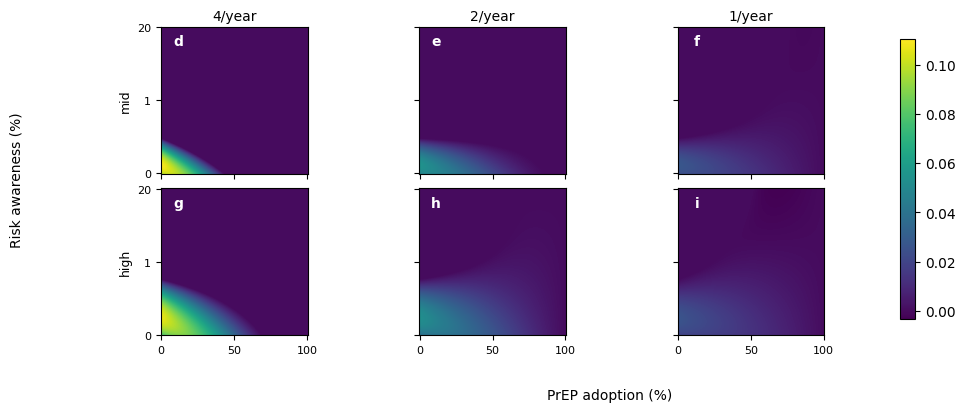

In [4]:
# plotting
# # Plot set-up
fig = plt.figure(figsize=(10.0, 4.0))

grid = fig.add_gridspec(2, 3, wspace=0, hspace=0.1)
axes = []
for i in range(2):
    row_axes = []
    for j in range(3):
        ax = fig.add_subplot(grid[i, j])
        row_axes.append(ax)
    axes.append(row_axes)

vmin = min([np.min(result) for row in results for result in row])
vmax = max([np.max(result) for row in results for result in row])
print(f"vmin: {vmin}, vmax: {vmax}")

for row_idx, beta_STI in enumerate(beta_STI_values):
    for col_idx, (lambda_P, label) in enumerate(zip(lambda_P_values, lambda_P_labels)):
        ax = axes[row_idx][col_idx]
        img = ax.imshow(results[row_idx][col_idx],origin="lower", vmin=vmin, vmax=vmax)
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels([int(Ps[0] * 100), int(Ps[100] * 100), int(Ps[200] * 100)], fontsize=8)
        ax.set_yticks([0, 100, 200])
        ax.set_yticklabels([int(Hs[0] * 100), int(Hs[50] * 100), int(Hs[100] * 100)], fontsize=8)

        if row_idx == 0:
            ax.set_title(f"{label}", fontsize=10, pad=5)
        if col_idx == 0:
            ax.set_ylabel(f"{beta_STI_labels[row_idx]}", fontsize=9)


        if row_idx == 1:
            ax.set_xticks([0, 100, 200])
            ax.set_xticklabels([int(Ps[0] * 100), int(Ps[100] * 100), int(Ps[200] * 100)], fontsize=8)
        else:
            ax.set_xticks([0, 100, 200])
            ax.set_xticklabels([])

        if col_idx == 0:
            ax.set_yticks([0, 100, 200])
            ax.set_yticklabels([int(Hs[0] * 100), int(Hs[10] * 100), int(Hs[200] * 100)], fontsize=8)
        else:
            ax.set_yticks([0, 100, 200])
            ax.set_yticklabels([])

# Add subpanel letters
for idx, ax in enumerate([ax for row_axes in axes for ax in row_axes]):
    ax.text(0.15,0.95,chr(97 + 3 + idx),transform=ax.transAxes,fontsize=10,fontweight="bold",va="top",ha="right",color="white",)

fig.text(0.63, -0.05, "PrEP adoption (%)", ha="center", fontsize=10)
fig.text(0.03,0.5,"Risk awareness (%)",va="center",rotation="vertical",fontsize=10)

cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(img, cax=cbar_ax)


plt.show()

fig.savefig("../figures/final_figure_withinflux_derivatives_crossproduct_sigma%g.pdf" % (args["Sigma"]), format="pdf", bbox_inches="tight")